# Getting started with DoWhy: A simple example
This is a quick introduction to the DoWhy causal inference library.
We will load in a sample dataset and estimate the causal effect of a (pre-specified)treatment variable on a (pre-specified) outcome variable.

First, let us add the required path for Python to find the DoWhy code and load all required packages.

In [1]:
import os, sys
sys.path.append(os.path.abspath("../../"))

In [2]:
import numpy as np
import pandas as pd

import dowhy
from dowhy.do_why import CausalModel
import dowhy.datasets 

Now, let us load a dataset. For simplicity, we simulate a dataset with linear relationships between common causes and treatment, and common causes and outcome. 

Beta is the true causal effect. 

In [3]:
data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=5,
        num_instruments = 2,
        num_samples=10000, 
        treatment_is_binary=True)
df = data["df"]
print(df.head())
print(data["dot_graph"])
print("\n")
print(data["gml_graph"])

    Z0        Z1        X0        X1        X2        X3        X4    v  \
0  0.0  0.207125  1.213390 -0.689592 -0.647086  2.121731 -0.023990  1.0   
1  1.0  0.573665  1.222764 -1.656263 -0.656267  1.279060 -0.747554  0.0   
2  1.0  0.849752 -0.269333  0.240212 -1.074635  0.459084 -1.601216  0.0   
3  0.0  0.744035  0.800602  1.106571 -1.372904  1.575653 -0.774460  1.0   
4  0.0  0.142626 -1.349769  0.024206 -0.341557  2.151439 -0.533915  0.0   

           y  
0  14.701809  
1  -3.926794  
2  -8.025821  
3  13.067669  
4   0.120526  
digraph { v ->y; U[label="Unobserved Confounders"]; U->v; U->y;X0-> v; X1-> v; X2-> v; X3-> v; X4-> v;X0-> y; X1-> y; X2-> y; X3-> y; X4-> y;Z0-> v; Z1-> v;}


graph[directed 1node[ id "v" label "v"]node[ id "y" label "y"]node[ id "Unobserved Confounders" label "Unobserved Confounders"]edge[source "v" target "y"]edge[source "Unobserved Confounders" target "v"]edge[source "Unobserved Confounders" target "y"]node[ id "X0" label "X0"] edge[ source "X0" targe

Note that we are using a pandas dataframe to load the data. At present, DoWhy only supports pandas dataframe as input.

## Interface 1 (recommended): Input causal graph

We now input a causal graph in the GML graph format (recommended). You can also use the DOT format.

In [4]:
# With graph
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"]
        )

INFO:dowhy.do_why:Model to find the causal effect of treatment ['v'] on outcome ['y']


In [5]:
model.view_model()

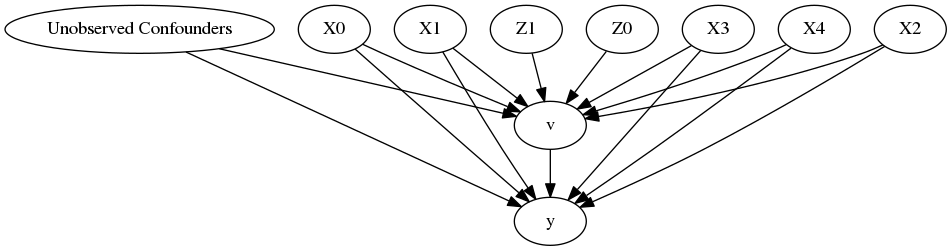

In [6]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

The above causal graph shows the assumptions encoded in the causal model. We can now use this graph to first identify 
the causal effect (go from a causal estimand to a probability expression), and then estimate the causal effect.

**DoWhy philosophy: Keep identification and estimation separate**

Identification can be achieved without access to the data, acccesing only the graph. This results in an expression to be computed. This expression can then be evaluated using the available data in the estimation step.
It is important to understand that these are orthogonal steps.

* Identification

In [7]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['X3', 'Unobserved Confounders', 'X2', 'X0', 'X1', 'Z1', 'Z0', 'X4']


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z1', 'Z0']


Estimand type: ate
### Estimand : 1
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z1)/Derivative(v, Z1))
Estimand assumption 1, Exclusion: If we remove {Z1,Z0}→v, then ¬(Z1,Z0→y)
Estimand assumption 2, As-if-random: If U→→y then ¬(U →→Z1,Z0)
### Estimand : 2
Estimand name: backdoor
Estimand expression:
d                                      
──(Expectation(y|X3,X2,X0,X1,Z1,Z0,X4))
dv                                     
Estimand assumption 1, Unconfoundedness: If U→v and U→y then P(y|v,X3,X2,X0,X1,Z1,Z0,X4,U) = P(y|v,X3,X2,X0,X1,Z1,Z0,X4)



* Estimation

In [8]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v+X3+X2+X0+X1+Z1+Z0+X4


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z1)/Derivative(v, Z1))
Estimand assumption 1, Exclusion: If we remove {Z1,Z0}→v, then ¬(Z1,Z0→y)
Estimand assumption 2, As-if-random: If U→→y then ¬(U →→Z1,Z0)
### Estimand : 2
Estimand name: backdoor
Estimand expression:
d                                      
──(Expectation(y|X3,X2,X0,X1,Z1,Z0,X4))
dv                                     
Estimand assumption 1, Unconfoundedness: If U→v and U→y then P(y|v,X3,X2,X0,X1,Z1,Z0,X4,U) = P(y|v,X3,X2,X0,X1,Z1,Z0,X4)

## Realized estimand
b: y~v+X3+X2+X0+X1+Z1+Z0+X4
## Estimate
Value: 9.999999999999716

Causal Estimate is 10.0


## Interface 2: Specify common causes and instruments

In [9]:
# Without graph                                       
model= CausalModel(                             
        data=df,                                      
        treatment=data["treatment_name"],             
        outcome=data["outcome_name"],                 
        common_causes=data["common_causes_names"])                         

INFO:dowhy.do_why:Model to find the causal effect of treatment ['v'] on outcome ['y']


In [10]:
model.view_model()

<img src="causal_model.png" />

We get the same causal graph. Now identification and estimation is done as before.

In [11]:
identified_estimand = model.identify_effect()                         

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['X3', 'U', 'X2', 'X0', 'X1', 'X4']


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


* Estimation

In [12]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression", 
        test_significance=True
        )         
print(estimate)
print("Causal Estimate is " + str(estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v+X3+X2+X0+X1+X4


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: iv
No such variable found!
### Estimand : 2
Estimand name: backdoor
Estimand expression:
d                                
──(Expectation(y|X3,X2,X0,X1,X4))
dv                               
Estimand assumption 1, Unconfoundedness: If U→v and U→y then P(y|v,X3,X2,X0,X1,X4,U) = P(y|v,X3,X2,X0,X1,X4)

## Realized estimand
b: y~v+X3+X2+X0+X1+X4
## Estimate
Value: 9.999999999999739

## Statistical Significance
p-value: <0.001

Causal Estimate is 10.0


## Refuting the estimate

Let us now look at ways of refuting the estimate obtained.

### Adding a random common cause variable

In [13]:
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v+X3+X2+X0+X1+X4+w_random


Refute: Add a Random Common Cause
Estimated effect:(9.9999999999997389,)
New effect:(9.9999999999997389,)



### Replacing treatment with a random (placebo) variable

In [14]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+X3+X2+X0+X1+X4


Refute: Use a Placebo Treatment
Estimated effect:(9.9999999999997389,)
New effect:(-0.053386232360657163,)



### Removing a random subset of the data

In [15]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)


INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v+X3+X2+X0+X1+X4


Refute: Use a subset of data
Estimated effect:(9.9999999999997389,)
New effect:(9.999999999999833,)



As you can see, the linear regression estimator is very sensitive to simple refutations.